# Classifier Comparison (Julia classifiers)

Adapted from http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

A comparison of a several classifiers in scikit-learn on synthetic datasets. The point of this example is to illustrate the nature of decision boundaries of different classifiers. This should be taken with a grain of salt, as the intuition conveyed by these examples does not necessarily carry over to real datasets.

Particularly in high-dimensional spaces, data can more easily be separated linearly and the simplicity of classifiers such as naive Bayes and linear SVMs might lead to better generalization than is achieved by other classifiers.

The plots show training points in solid colors and testing points semi-transparent. The lower right shows the classification accuracy on the test set.

In [1]:
# Python Code source: Gaël Varoquaux
#                     Andreas Müller
# Julia adaptation: Cédric St-Jean
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

using ScikitLearn
using PyCall
using PyPlot
using ScikitLearn.CrossValidation: train_test_split
import DecisionTree
using ScikitLearn.Models: DecisionTreeClassifier, RandomForestClassifier, AdaBoostStumpClassifier
@pyimport matplotlib.colors as mplc
@sk_import preprocessing: StandardScaler
@sk_import datasets: (make_moons, make_circles, make_classification)
@sk_import neighbors: KNeighborsClassifier
@sk_import svm: SVC
#@sk_import tree: DecisionTreeClassifier
@sk_import ensemble: (AdaBoostClassifier) # RandomForestClassifier
@sk_import naive_bayes: GaussianNB
@sk_import discriminant_analysis: (LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis)
using ScikitLearn.Utils: meshgrid

In [2]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree (Julia)",
         "Random Forest (Julia)", "AdaBoost (Julia)", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(pruning_purity_threshold=0.8),
    RandomForestClassifier(ntrees=20),
    AdaBoostStumpClassifier(niterations=30),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()
]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
srand(42)
X += 2 * rand(size(X)...)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ];

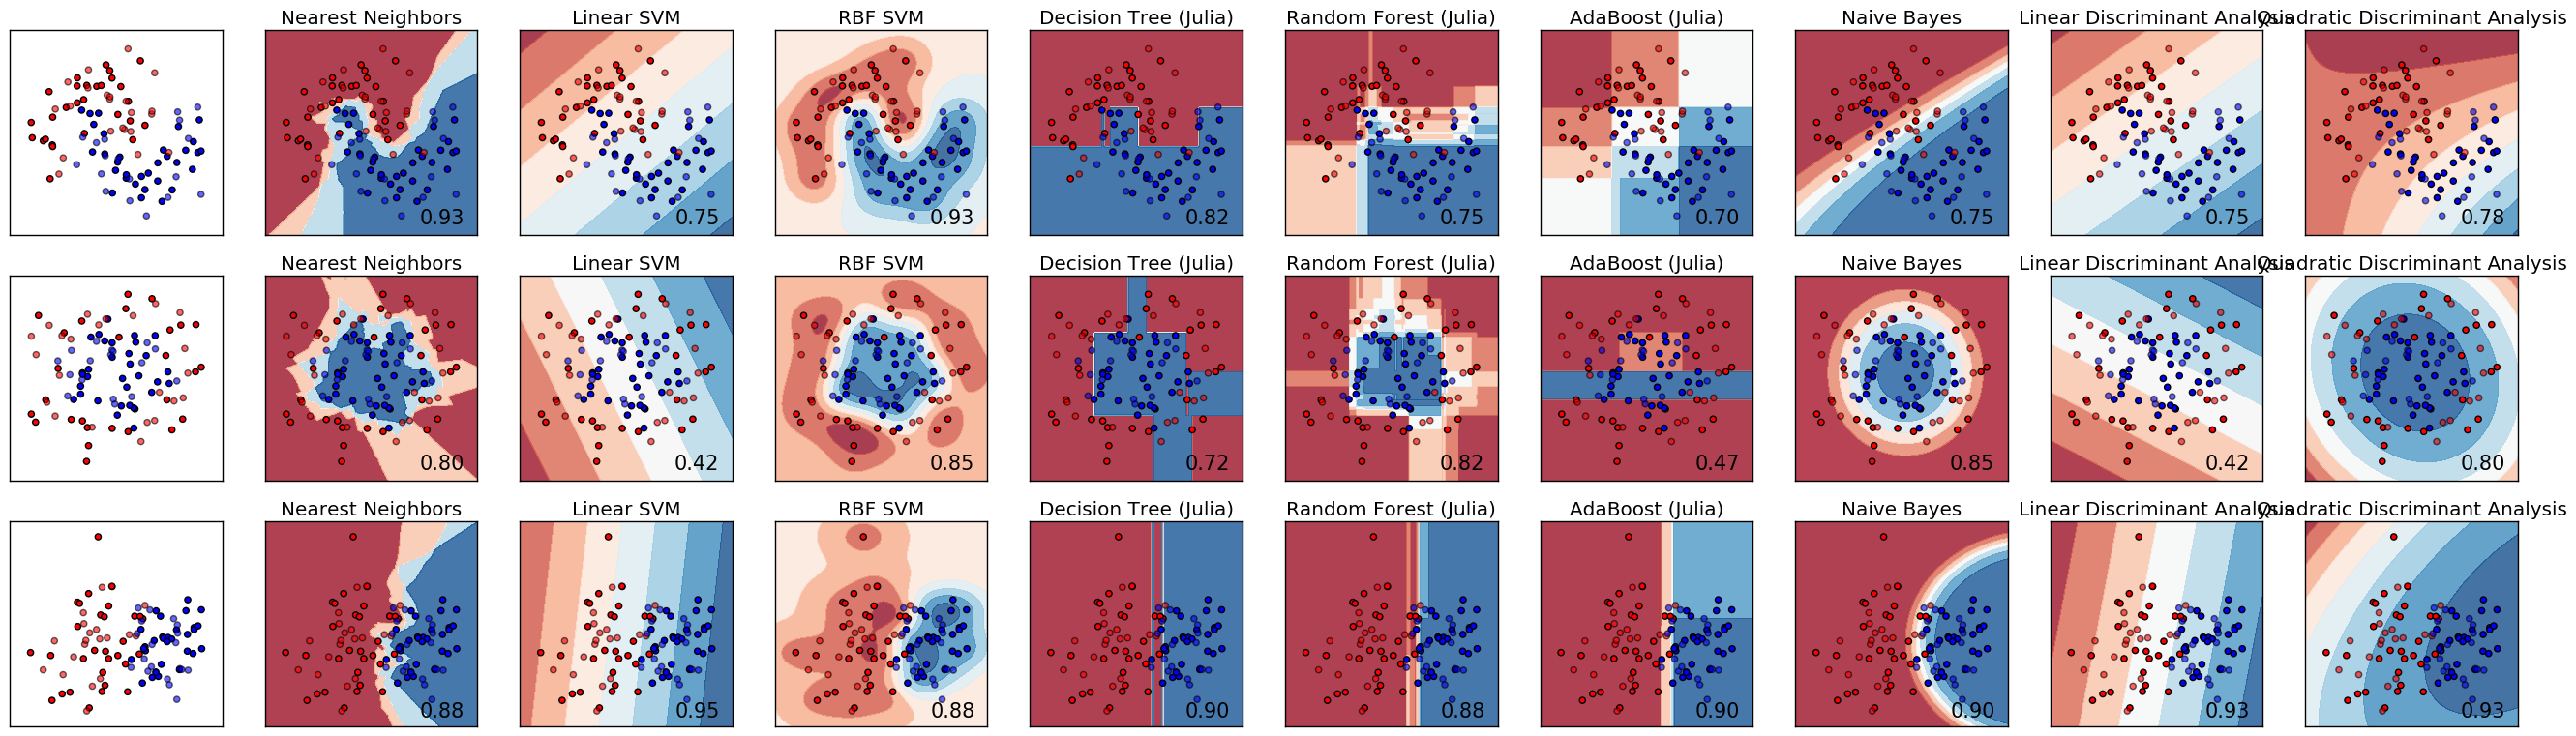

In [3]:
fig = figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets
    # preprocess dataset, split into training and test part
    X, y = ds
    X = fit_transform!(StandardScaler(), X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = minimum(X[:, 1]) - .5, maximum(X[:, 1]) + .5
    y_min, y_max = minimum(X[:, 2]) - .5, maximum(X[:, 2]) + .5
    xx, yy = meshgrid(x_min:h:x_max, y_min:h:y_max)

    # just plot the dataset first
    cm = PyPlot.cm[:RdBu]
    cm_bright = mplc.ListedColormap(["#FF0000", "#0000FF"])
    ax = subplot(length(datasets), length(classifiers) + 1, i)
    # Plot the training points
    ax[:scatter](X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright)
    # and testing points
    ax[:scatter](X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright, alpha=0.6)

    ax[:set_xlim](minimum(xx), maximum(xx))
    ax[:set_ylim](minimum(yy), maximum(yy))
    ax[:set_xticks](())
    ax[:set_yticks](())
    i += 1

    # iterate over classifiers
    for (name, clf) in zip(names, classifiers)
        ax = subplot(length(datasets), length(classifiers) + 1, i)
        fit!(clf, X_train, y_train)
        scor = score(clf, X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        try 
            # Not implemented for some
            Z = decision_function(clf, hcat(xx[:], yy[:]))
        catch
            Z = predict_proba(clf, hcat(xx[:], yy[:]))[:, 2]
        end

        # Put the result into a color plot
        Z = reshape(Z, size(xx)...)
        ax[:contourf](xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax[:scatter](X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright)
        # and testing points
        ax[:scatter](X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax[:set_xlim](minimum(xx), maximum(xx))
        ax[:set_ylim](minimum(yy), maximum(yy))
        ax[:set_xticks](())
        ax[:set_yticks](())
        ax[:set_title](name)

        ax[:text](maximum(xx) - .3, minimum(yy) + .3, @sprintf("%.2f", scor),
                size=15, horizontalalignment="right")
        i += 1
    end
end
fig[:subplots_adjust](left=.02, right=.98)